In [1]:
%load_ext autoreload

%autoreload complete

# Pulse parametrization for Magnus Expansion

In [7]:
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scipy.linalg as la

from qcheff.magnus import MagnusTimeEvol

matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["font.size"] = 25
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["text.usetex"] = False

## Ramp for control functions.

We will use the pulse given in the [paper](https://iopscience.iop.org/article/10.1088/1361-6455/ac6366). However, we will define everything much like in the Magnus-Taylor case, so that the timelist is divided by the total gate time and the ratio of ramp time to gate time is given by the symbol $a$. This way, the time list is bounded between 0 and 1, and we can later multiply it by arbitary time to stretch it. 

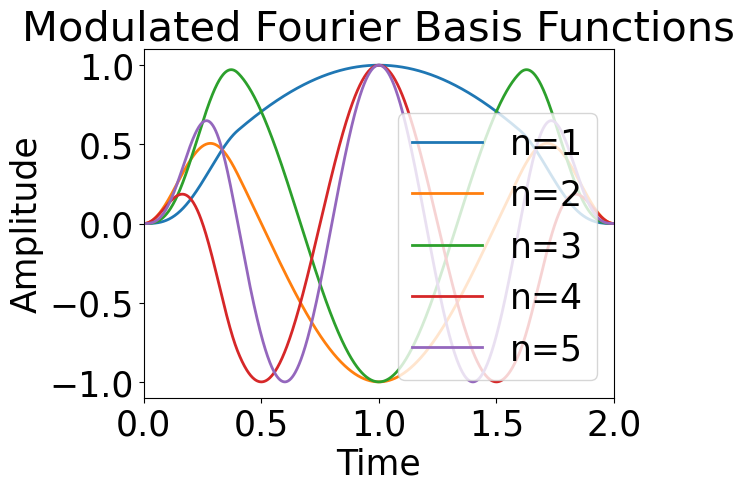

In [5]:
from pulse_viz_utils import plot_basis_funcs, plot_example_control_pulse

plot_basis_funcs()

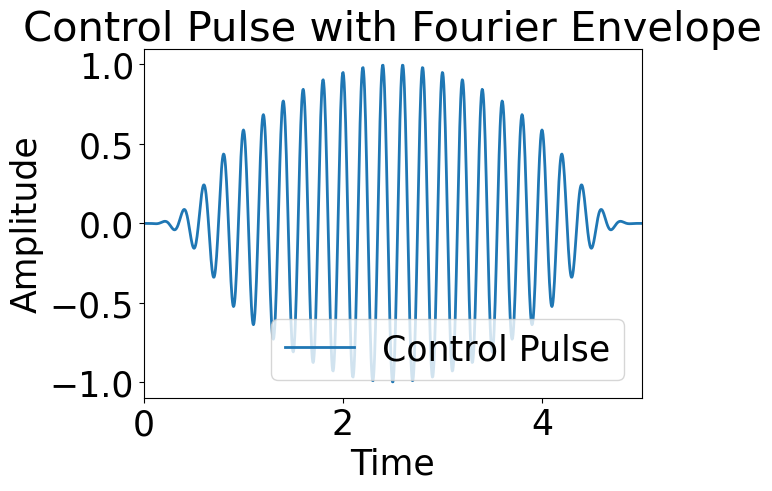

In [6]:
plot_example_control_pulse(
    gate_time=5,
)

## Testing Hamiltonian generation base-cases

In [8]:
from qcheff.magnus.pulses import ControlPulse, FourierPulseEnvelope
from qcheff.magnus.system import System


def plot_matelm_mag(H: np.ndarray, scale="log"):
    fig, ax = plt.subplots(1, 1, layout="constrained")
    absH = np.abs(H)
    P1 = ax.imshow(
        absH.get(),
        cmap="binary",
        norm=mpl.colors.LogNorm(vmin=1e-10) if scale == "log" else None,
    )
    ax.set(xticks=[], yticks=[])
    plt.colorbar(P1, ax=ax)


def plot_offdiag_mag(H: np.ndarray, scale="log"):
    plot_matelm_mag(H - np.diag(np.diagonal(H)), scale=scale)


def create_single_spin_system(drive_freq=1.0):
    drift_ham = -np.pi * qt.sigmaz()  # qubit frequency = 1
    control_sigs = [
        ControlPulse(
            FourierPulseEnvelope([1], gate_time=5),
            frequency=drive_freq,
            amplitude=1,
        )
    ]
    control_hams = [qt.sigmax()]
    system = System(drift_ham, control_sigs, control_hams)
    return system


def simulate_and_plot(ham: qt.QobjEvo, tlist, fig=None, ax=None):
    # Initial state is the ground state
    psi0 = qt.basis(2, 0)
    sigma_ops = [qt.sigmax(), qt.sigmay(), qt.sigmaz()]

    # Time evolution
    result = qt.sesolve(
        ham,
        psi0,
        tlist=tlist,
        e_ops=sigma_ops,
        options={"progress_bar": False},
    )

    xt, yt, zt = result.expect
    # Check if both fig and ax are None, then make new plot and axes
    if ax is None or fig is None:
        fig = plt.figure(layout="tight", figsize=(8, 8))
        ax = fig.add_subplot(projection="3d")

    b = qt.Bloch(fig=fig, axes=ax)
    b.sphere_color = "white"
    b.sphere_alpha = 0.1
    b.render()
    ax.set(xlim3d=(-1, 1), ylim3d=(-1, 1), zlim3d=(-1, 1))
    ax.plot(xt, yt, zt, lw=2, color="tab:red")
    ax.legend()

This makes sense. When the drive is on-resonance, we see the qubit being driven (Rabi oscillations). However, when the drive frequency is different from the qubit frequency, the oscillations are incomplete.

## Testing the Magnus expansion.

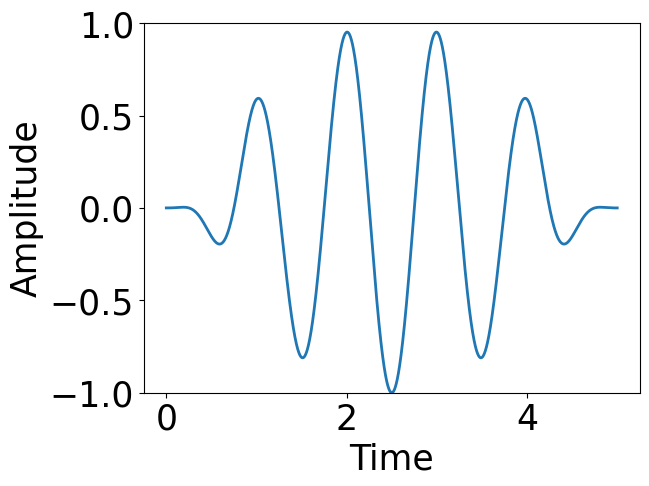

In [11]:
test_sys = create_single_spin_system(drive_freq=1)
test_tlist = np.linspace(0, 5, 100000)
test_sys.plot_control_signals(tlist=test_tlist)

In [12]:
test_magnus = MagnusTimeEvol(test_sys, tlist=test_tlist)

props = [qt.Qobj(mag) for mag in test_magnus.magnus1(num_intervals=1000)]
test_states = [qt.basis(2, 0)]

for prop in props:
    new_state = prop * test_states[-1]
    test_states.append(new_state)

7.72476686109469e-05

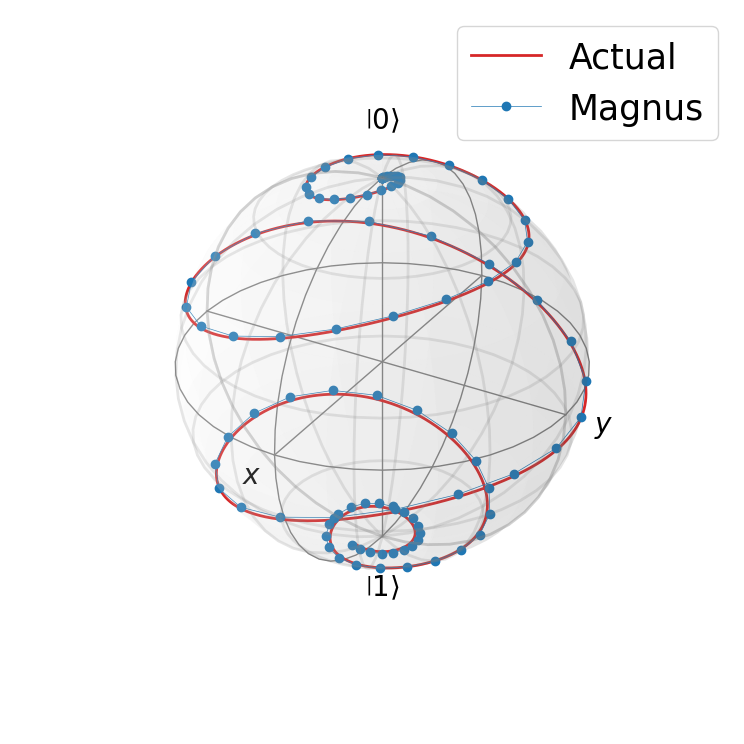

In [13]:
def test_magnus_acc(
    test_sys: System, test_tlist: np.ndarray, num_magnus_intervals: int, plot=False
):
    """
    Given a system and time list, compare the accuracy of the magnus expansion for a
    given number of magnus intervals.
    """
    test_magnus = MagnusTimeEvol(test_sys, tlist=test_tlist)
    props = [
        qt.Qobj(mag) for mag in test_magnus.magnus1(num_intervals=num_magnus_intervals)
    ]
    psi0 = qt.basis(2, 0)
    sigma_ops = [qt.sigmax(), qt.sigmay(), qt.sigmaz()]
    mag_states = [psi0]

    # Time evolution
    result = qt.sesolve(
        test_sys.get_tdham(test_tlist),
        psi0,
        tlist=test_tlist,
        options={"progress_bar": False, "store_states": True},
    )

    for prop in props:
        new_state = prop * mag_states[-1]
        mag_states.append(new_state)

    # mag_states = [qt.Qobj(mag)@psi0 for mag in test_magnus.magnus1(num_intervals=num_magnus_intervals)]

    if plot:
        xt_full, yt_full, zt_full = qt.expect(sigma_ops, result.states)
        xt_mag, yt_mag, zt_mag = qt.expect(sigma_ops, mag_states)
        fig = plt.figure(layout="tight", figsize=(8, 8))
        ax = fig.add_subplot(projection="3d")
        b = qt.Bloch(fig=fig, axes=ax)
        b.sphere_color = "white"
        b.sphere_alpha = 0.1
        b.zlpos = [1.3, -1.3]
        b.render()
        ax.set(xlim3d=(-1, 1), ylim3d=(-1, 1), zlim3d=(-1, 1))
        full_trajectory = ax.plot(
            xt_full, yt_full, zt_full, color="tab:red", lw=2, label="Actual"
        )
        magnus_trajectory = ax.plot(
            xt_mag, yt_mag, zt_mag, color="tab:blue", marker="o", lw=0.5, label="Magnus"
        )
        ax.legend(handles=[full_trajectory[0], magnus_trajectory[0]], fontsize=25)

    return 1 - np.abs(qt.Qobj(mag_states[-1]).overlap(result.states[-1]))


test_magnus_acc(
    test_sys=test_sys, test_tlist=test_tlist, num_magnus_intervals=100, plot=True
)

[Text(0.5, 0, '# Magnus Intervals'), Text(0, 0.5, 'Error')]

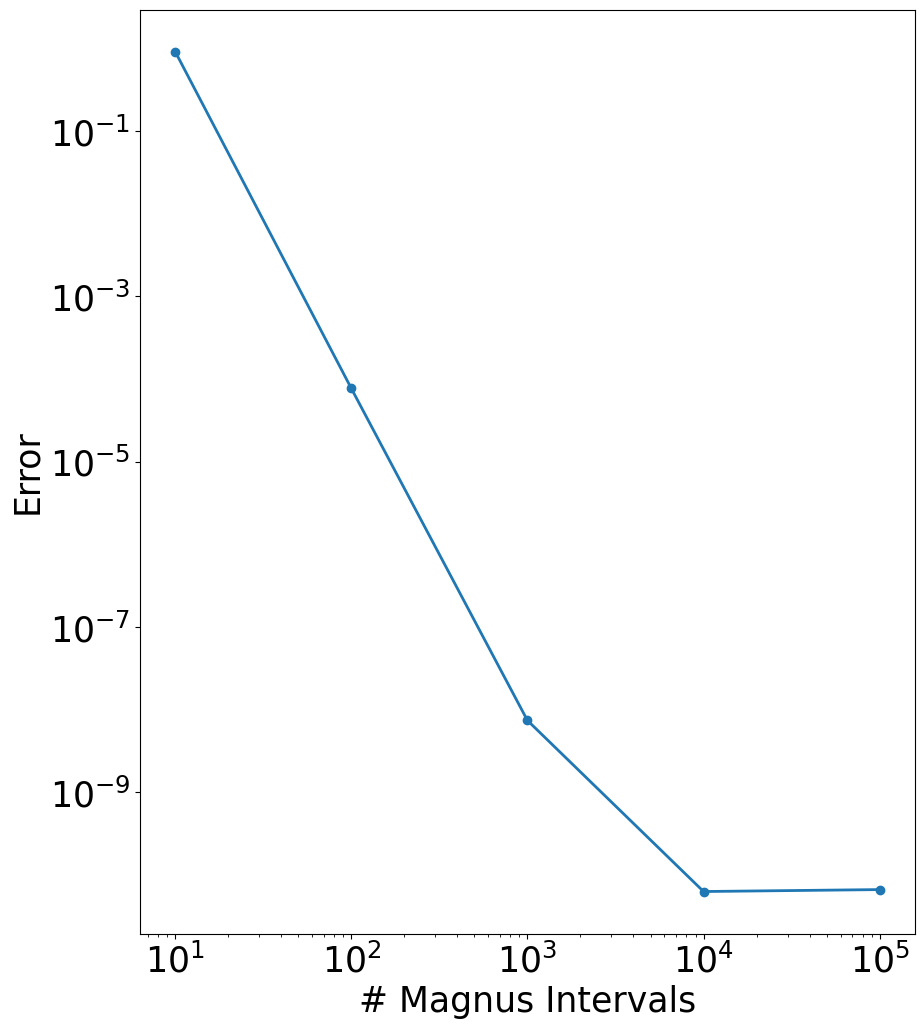

In [14]:
num_mag_list = np.logspace(1, 5, 5, dtype=int)
err_list = [
    test_magnus_acc(test_sys=test_sys, test_tlist=test_tlist, num_magnus_intervals=num)
    for num in num_mag_list
]
fig, ax = plt.subplots(figsize=(10, 12))
ax.loglog(num_mag_list, err_list, marker="o")
ax.set(xlabel="# Magnus Intervals", ylabel="Error")